# Preventing Hospitalizations with Machine Learning

## Data Cleaning and Engineering

### Medical Conditions
As mentioned in the [main project notebook](https://github.com/lilisbeit/nhanes/blob/main/overview-and-modeling.ipynb), most of the data manipulation for this project involved altering the medical conditions data to show only those conditions which patients have had for 12 months or more. Since the target is hospitalizations within the past year, I only used medical conditions as predictors if patients were diagnosed with them prior to one year ago. The one exception to this rule was Chronic Obstructive Pulmonary Disease (COPD). NHANES did not include a variable asking how long the participant had COPD, unlike for the other medical conditions. The only COPD variable asked if patients ever had COPD. Since COPD is an important predictor of hospitalizations, I included it in the model even though it's possible some patients did not know they had COPD prior to being hospitalized.

### Exclusion of Hospitalizations for Childbirth
Since this analysis does not focus on predicting hospitalizations for childbirth, which are predictable through other methods, I excluded these hospitalizations from the target.  Patients who gave birth within the past 12 months had one hospitalization subtracted from their total number of hospitalizations during the past year.


### Import Python Libraries

In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import utils as ut

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)

### Import NHANES Data
The files below can be downloaded from the NHANES website using these links:

[Demographics](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Demographics&CycleBeginYear=2017)

[Questionnaire Data](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2017)


In [2]:
# import NHANES data

demo_j = ut.import_and_decode('data/demo_j.xpt') # demographics
diq_j = ut.import_and_decode('data/diq_j.xpt') # diabetes
huq_j = ut.import_and_decode('data/huq_j.xpt') # hospital utilization and access to care
mcq_j = ut.import_and_decode('data/mcq_j.xpt') # medical conditions
rxq_rx_j = ut.import_and_decode('data/rxq_rx_j.xpt') # prescription drug use
rhq_j = ut.import_and_decode('data/rhq_j.xpt') # reproductive health


### Create DataFrame with patient age
Age df will be necessary to tell if patients had medical conditions for over 1 year

In [3]:
# demographic info is in this df - get participant age RIDAGEYR

demo_j

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,93703.00000,10.00000,2.00000,2.00000,2.00000,nan,5.00000,6.00000,2.00000,27.00000,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,nan,nan,nan,nan,5.00000,5.00000,3.00000,0.00000,0.00000,1.00000,2.00000,3.00000,1.00000,3.00000,9246.49186,8539.73135,2.00000,145.00000,15.00000,15.00000,5.00000
1,93704.00000,10.00000,2.00000,1.00000,2.00000,nan,3.00000,3.00000,1.00000,33.00000,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,nan,nan,nan,nan,4.00000,4.00000,2.00000,0.00000,0.00000,1.00000,2.00000,3.00000,1.00000,2.00000,37338.76834,42566.61475,1.00000,143.00000,15.00000,15.00000,5.00000
2,93705.00000,10.00000,2.00000,2.00000,66.00000,nan,4.00000,4.00000,2.00000,nan,2.00000,nan,1.00000,1.00000,nan,nan,2.00000,3.00000,nan,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,2.00000,4.00000,1.00000,2.00000,nan,8614.57117,8338.41979,2.00000,145.00000,3.00000,3.00000,0.82000
3,93706.00000,10.00000,2.00000,1.00000,18.00000,nan,5.00000,6.00000,2.00000,222.00000,2.00000,nan,1.00000,1.00000,nan,15.00000,nan,nan,nan,1.00000,2.00000,2.00000,nan,nan,nan,1.00000,2.00000,2.00000,1.00000,5.00000,5.00000,0.00000,0.00000,1.00000,1.00000,4.00000,3.00000,1.00000,2.00000,8548.63262,8723.43981,2.00000,134.00000,nan,nan,nan
4,93707.00000,10.00000,2.00000,1.00000,13.00000,nan,5.00000,7.00000,2.00000,158.00000,nan,nan,1.00000,1.00000,nan,6.00000,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,7.00000,7.00000,0.00000,3.00000,0.00000,1.00000,3.00000,2.00000,1.00000,3.00000,6769.34457,7064.60973,1.00000,138.00000,10.00000,10.00000,1.88000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9249,102952.00000,10.00000,2.00000,2.00000,70.00000,nan,5.00000,6.00000,2.00000,nan,2.00000,nan,2.00000,1.00000,7.00000,nan,3.00000,1.00000,nan,1.00000,2.00000,1.00000,1.00000,2.00000,1.00000,1.00000,2.00000,1.00000,nan,2.00000,2.00000,0.00000,0.00000,2.00000,2.00000,4.00000,2.00000,1.00000,1.00000,16896.27620,18338.71110,2.00000,138.00000,4.00000,4.00000,0.95000
9250,102953.00000,10.00000,2.00000,1.00000,42.00000,nan,1.00000,1.00000,2.00000,nan,2.00000,nan,2.00000,2.00000,77.00000,nan,3.00000,4.00000,nan,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,3.00000,2.00000,2.00000,nan,61630.38001,63661.95157,2.00000,137.00000,12.00000,12.00000,nan
9251,102954.00000,10.00000,2.00000,2.00000,41.00000,nan,4.00000,4.00000,1.00000,nan,2.00000,nan,1.00000,1.00000,nan,nan,5.00000,5.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,7.00000,7.00000,3.00000,1.00000,0.00000,2.00000,3.00000,2.00000,2.00000,nan,17160.89527,17694.78335,1.00000,144.00000,10.00000,10.00000,1.18000
9252,102955.00000,10.00000,2.00000,2.00000,14.00000,nan,4.00000,4.00000,2.00000,175.00000,nan,nan,1.00000,1.00000,nan,8.00000,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,4.00000,4.00000,0.00000,1.00000,0.00000,2.00000,3.00000,2.00000,1.00000,2.00000,14238.44592,14871.83964,1.00000,136.00000,9.00000,9.00000,2.24000


In [4]:
# check for duplicate participant ID numbers

demo_j['SEQN'].duplicated().sum()

0

In [5]:
# create age df to join later

age = demo_j[['SEQN', 'RIDAGEYR']]

In [6]:
# check if all participants have a valid age

age['RIDAGEYR'].value_counts()

80.00000    427
0.00000     357
2.00000     242
1.00000     234
9.00000     199
10.00000    199
8.00000     195
11.00000    189
3.00000     185
4.00000     180
5.00000     178
7.00000     168
6.00000     165
14.00000    159
16.00000    157
12.00000    156
13.00000    152
17.00000    148
61.00000    145
18.00000    144
19.00000    143
60.00000    141
15.00000    135
63.00000    129
62.00000    123
55.00000    121
64.00000    112
33.00000    104
56.00000    104
66.00000    103
54.00000     99
52.00000     99
57.00000     97
41.00000     96
29.00000     95
65.00000     93
32.00000     92
24.00000     92
67.00000     91
22.00000     90
59.00000     90
71.00000     89
26.00000     89
36.00000     88
46.00000     86
42.00000     85
30.00000     85
28.00000     85
47.00000     85
69.00000     85
45.00000     85
39.00000     85
70.00000     83
68.00000     82
38.00000     82
34.00000     82
48.00000     82
35.00000     81
37.00000     81
50.00000     80
23.00000     80
44.00000     79
53.00000

Text(0.5, 1.0, 'NHANES Participant Age Distribution, 2017-2018')

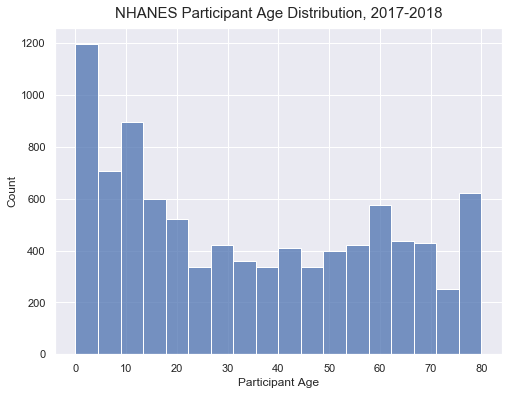

In [7]:
# view age distribution

sns.set(rc={'figure.figsize':(8, 6)})
ax = sns.histplot(age['RIDAGEYR'])
ax.set(xlabel='Participant Age')
ax.set_title('NHANES Participant Age Distribution, 2017-2018', fontsize=15, pad=10)

# all respondents 80 and older are top-coded at 80

### Create DataFrame with target

In [8]:
# target can be found in this df
# target is HUD071 - were you a pt in a hospital during the past 12 months?

huq_j

,SEQN,HUQ010,HUQ020,HUQ030,HUQ041,HUQ051,HUQ061,HUQ071,HUD080,HUQ090
0,93703.00000,1.00000,3.00000,1.00000,2.00000,3.00000,nan,2.00000,nan,nan
1,93704.00000,1.00000,3.00000,1.00000,2.00000,2.00000,nan,2.00000,nan,nan
2,93705.00000,3.00000,3.00000,1.00000,1.00000,2.00000,nan,2.00000,nan,2.00000
3,93706.00000,1.00000,3.00000,1.00000,2.00000,2.00000,nan,2.00000,nan,2.00000
4,93707.00000,3.00000,3.00000,1.00000,2.00000,1.00000,nan,2.00000,nan,1.00000
...,...,...,...,...,...,...,...,...,...,...
9249,102952.00000,2.00000,3.00000,1.00000,2.00000,2.00000,nan,2.00000,nan,2.00000
9250,102953.00000,4.00000,2.00000,1.00000,1.00000,6.00000,nan,2.00000,nan,2.00000
9251,102954.00000,2.00000,1.00000,1.00000,2.00000,3.00000,nan,2.00000,nan,2.00000
9252,102955.00000,3.00000,1.00000,1.00000,2.00000,0.00000,2.00000,2.00000,nan,2.00000


**Target question:**

HUQ071	Overnight hospital patient in last year	
During the past 12 months, were you/was SP a patient in a hospital overnight? Do not include an overnight stay in the emergency room.	

In [9]:
# create target df to join later

target = huq_j[['SEQN', 'HUQ071']]
target

,SEQN,HUQ071
0,93703.00000,2.00000
1,93704.00000,2.00000
2,93705.00000,2.00000
3,93706.00000,2.00000
4,93707.00000,2.00000
...,...,...
9249,102952.00000,2.00000
9250,102953.00000,2.00000
9251,102954.00000,2.00000
9252,102955.00000,2.00000


In [10]:
# check for duplicates

target.duplicated().sum()

0

In [11]:
# make binary target into 0 (no) and 1 (yes), not 2 and 1

target.loc[target['HUQ071'] == 2, 'HUQ071'] = 0

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
target['HUQ071'].value_counts()

# three responses of don't know
# these rows should be removed

0.00000    8434
1.00000     817
9.00000       3
Name: HUQ071, dtype: int64

In [13]:
# remove 3 patients with '9' response ("don't know")

target = target.loc[target['HUQ071'] != 9.00000]

In [14]:
target['HUQ071'].value_counts(normalize=True)

# only 9 per cent of people were hospitalized

0.00000   0.91169
1.00000   0.08831
Name: HUQ071, dtype: float64

In [15]:
# make df to plot doughnut

target_ratio = pd.DataFrame(target['HUQ071'].value_counts(normalize=True))
target_ratio.rename(index = {0.00000: 'No', 1.00000: 'Yes'}, inplace=True)
target_ratio

,HUQ071
No,0.91169
Yes,0.08831


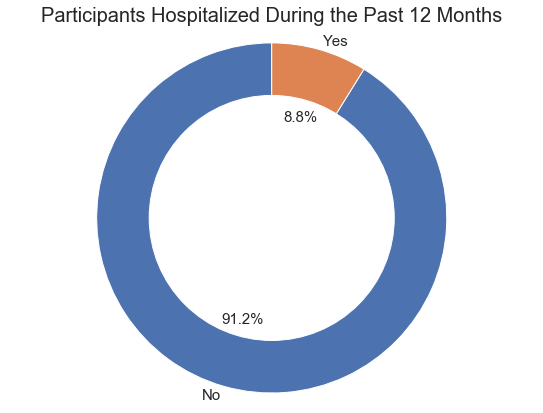

In [16]:
# plot doughnut chart to show target distribution
# minority class is very small

# credit to Kevin Anipara for code
# https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(target_ratio['HUQ071'], 
        labels=target_ratio.index,
        autopct='%1.1f%%',
        labeldistance=1.05,
        startangle=90,
        textprops = {"fontsize":15})
ax1.set_title('Participants Hospitalized During the Past 12 Months', pad=10, fontsize=20)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('images/label-distribution-pie', bbox_inches='tight')

## Data Cleaning - Medical Conditions
Cleaned medical conditions data to only show diagnoses participants have had for more than one year.

Made the following changes:
* when age of diagnosis is missing (very few cases), impute median age of diagnosis
* make osteoarthritis a variable; combine all other arthritis columns into "other arthritis" variable
* make heart failure a variable; combine all other circulatory conditions into "other circulatory" variable
* for asthma and chronic bronchitis, data is available on whether participant still has this condition
* --> update these two conditions to reflect 0 if participant no longer has it

Created 2 medical conditions DataFrames for testing, one with Boolean yes/no variables, and one with continuous variables for showing how many years patient has had each condition.  Initial variables tested include:


In [17]:
# create a DataFrame of medical conditions most likely to lead to hospitalization according to AJMC article 

# start with medical conditions most likely to lead to an inpatient admission:
# circulatory system (in particular heart failure)
# respiratory system (in particular COPD)
# diabetes
# osteoarthritis


In [18]:
# NHANES medical conditions df

mcq_j


,SEQN,MCQ010,MCQ025,MCQ035,MCQ040,MCQ050,AGQ030,MCQ053,MCQ080,MCQ092,MCD093,MCQ149,MCQ151,RHD018,MCQ160A,MCD180A,MCQ195,MCQ160N,MCD180N,MCQ160B,MCD180B,MCQ160C,MCD180C,MCQ160D,MCD180D,MCQ160E,MCD180E,MCQ160F,MCD180F,MCQ160M,MCQ170M,MCD180M,MCQ160G,MCD180G,MCQ160K,MCQ170K,MCD180K,MCQ160O,MCQ160L,MCQ170L,MCD180L,MCQ500,MCQ510A,MCQ510B,MCQ510C,MCQ510D,MCQ510E,MCQ510F,MCQ520,MCQ530,MCQ540,MCQ550,MCQ560,MCQ570,MCQ203,MCQ206,MCQ220,MCQ230A,MCD240A,MCQ230B,MCD240B,MCQ230C,MCD240C,MCQ230D,MCQ300B,MCQ300C,MCQ300A,MCQ366A,MCQ366B,MCQ366C,MCQ366D,MCQ371A,MCQ371B,MCQ371C,MCQ371D,OSQ230
0,93703.00000,2.00000,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,93704.00000,2.00000,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,93705.00000,1.00000,10.00000,2.00000,nan,nan,nan,2.00000,2.00000,2.00000,nan,nan,nan,nan,1.00000,64.00000,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,1.00000,1.00000,2.00000
3,93706.00000,2.00000,nan,nan,nan,nan,nan,2.00000,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,nan
4,93707.00000,2.00000,nan,nan,nan,nan,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,102952.00000,2.00000,nan,nan,nan,nan,nan,2.00000,2.00000,2.00000,nan,nan,nan,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,1.00000,1.00000,2.00000
8893,102953.00000,1.00000,42.00000,1.00000,1.00000,2.00000,1.00000,2.00000,1.00000,2.00000,nan,nan,nan,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,1.00000,2.00000,34.00000,nan,nan,nan,nan,nan,nan,6.00000,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,1.00000,2.00000,2.00000,1.00000,1.00000,1.00000,1.00000,2.00000,2.00000,2.00000,2.00000,2.00000
8894,102954.00000,2.00000,nan,nan,nan,nan,nan,2.00000,1.00000,2.00000,nan,nan,nan,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,1.0

In [19]:
# view columns of interest

mcq_j[['SEQN',
      'MCD180A', # age when told you had arthritis
      'MCQ195', # which type of arthritis was it
      'MCD180B', # age when told you had heart failure
     'MCD180C', # age when told you had CAD
     'MCD180D', # age when told you had angina pectoris
     'MCD180E', # age when told you had a heart attack
     'MCD180F', # age when told you had a stroke
     'MCD180G', # age when told you had emphysema
     'MCD180K', # age when told you had chronic bronchitis
      'MCQ170K', # do you still have chronic brochitis
     'MCQ160O', # ever told you had COPD?
     'MCD180L', # age when told you had a liver condition
     'MCQ170L', # do you still have a liver condition
     'MCQ510A', # Liver condition: Fatty liver
     'MCQ510B', # Liver condition: Liver fibrosis
      'MCQ510C', # Liver condition: Liver cirrhosis
     'MCQ510D', # Liver condition: Viral hepatitis
     'MCQ510E', # Liver condition: Autoimmune hepatitis 
     'MCQ510F', # Liver condition: Other liver disease
     'MCD180M', # Age when told you had thyroid problem
     'MCQ170M', # Do you still have thyroid problem
     'MCD180N', # MCD180n - Age when told you had gout
     'MCD240A', # Age 1st cancer (MCQ230a) diagnosed
     'MCD240B', # Age 2nd cancer (MCQ230b) diagnosed
     'MCD240C', # Age 3rd cancer (MCQ230c) diagnosed
     'MCQ230A', # 1st cancer - what kind was it?
      'MCQ230B', # 2nd cancer - what kind was it?
      'MCQ230C', # 3rd cancer - what kind was it?
     'MCQ025', # age when first had asthma
     'MCQ035', # still have asthma
     'MCQ206', # Age when told you have jaundice?
     'MCQ300A', # Close relative had heart attack?
     'MCQ300B', # Close relative had asthma?
     'MCQ300C', # Close relative had diabetes?
     'MCQ570' # Age when 1st had gallbladder surgery?
     ]]

,SEQN,MCD180A,MCQ195,MCD180B,MCD180C,MCD180D,MCD180E,MCD180F,MCD180G,MCD180K,MCQ170K,MCQ160O,MCD180L,MCQ170L,MCQ510A,MCQ510B,MCQ510C,MCQ510D,MCQ510E,MCQ510F,MCD180M,MCQ170M,MCD180N,MCD240A,MCD240B,MCD240C,MCQ230A,MCQ230B,MCQ230C,MCQ025,MCQ035,MCQ206,MCQ300A,MCQ300B,MCQ300C,MCQ570
0,93703.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,93705.00000,64.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,10.00000,2.00000,nan,2.00000,1.00000,1.00000,nan
3,93706.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,102952.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,2.00000,2.00000,nan
8893,102953.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,34.00000,2.00000,nan,nan,nan,nan,nan,6.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,42.00000,1.00000,nan,2.00000,1.00000,2.00000,nan
8894,102954.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,1.00000,1.00000,nan
8895,102955.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan


### Create clean arthritis dfs - 1 df with continuous and 1 df with binary variables for testing

In [20]:
# pull out arthritis columns

arthritis = mcq_j[['SEQN', 'MCQ195', 'MCD180A']]
arthritis

,SEQN,MCQ195,MCD180A
0,93703.00000,nan,nan
1,93704.00000,nan,nan
2,93705.00000,2.00000,64.00000
3,93706.00000,nan,nan
4,93707.00000,nan,nan
...,...,...,...
8892,102952.00000,nan,nan
8893,102953.00000,nan,nan
8894,102954.00000,nan,nan
8895,102955.00000,nan,nan


In [21]:
# look at kinds of arthritis

arthritis['MCQ195'].value_counts()

# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 1	Osteoarthritis or degenerative arthritis	711	711	
# 2	Rheumatoid arthritis	337	1048	
# 3	Psoriatic arthritis	26	1074	
# 4	Other	175	1249	
# 7	Refused	3	1252	
# 9	Don't know	443	1695	
# .	Missing	7202	8897	

1.00000    711
9.00000    443
2.00000    337
4.00000    175
3.00000     26
7.00000      3
Name: MCQ195, dtype: int64

In [22]:
# encode kinds of arthritis

arthritis_2 = pd.get_dummies(data=arthritis, columns=['MCQ195'])
arthritis_2

,SEQN,MCD180A,MCQ195_1.0,MCQ195_2.0,MCQ195_3.0,MCQ195_4.0,MCQ195_7.0,MCQ195_9.0
0,93703.00000,nan,0,0,0,0,0,0
1,93704.00000,nan,0,0,0,0,0,0
2,93705.00000,64.00000,0,1,0,0,0,0
3,93706.00000,nan,0,0,0,0,0,0
4,93707.00000,nan,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
8892,102952.00000,nan,0,0,0,0,0,0
8893,102953.00000,nan,0,0,0,0,0,0
8894,102954.00000,nan,0,0,0,0,0,0
8895,102955.00000,nan,0,0,0,0,0,0


In [23]:
# osteoarthritis is most likely to cause hospitalization according to AJMC article 
# give osteoarthritis its own column and combine all other kinds

arthritis_3 = arthritis_2.rename(columns = {'MCQ195_1.0': 'osteoarthritis'})

other_arth = ['MCQ195_2.0', 'MCQ195_3.0', 'MCQ195_4.0', 'MCQ195_7.0', 'MCQ195_9.0']

arthritis_3['other_arthritis'] = arthritis_3[other_arth].sum(axis = 1)

arthritis_4 = arthritis_3.drop(columns = other_arth)

arthritis_4

,SEQN,MCD180A,osteoarthritis,other_arthritis
0,93703.00000,nan,0,0
1,93704.00000,nan,0,0
2,93705.00000,64.00000,0,1
3,93706.00000,nan,0,0
4,93707.00000,nan,0,0
...,...,...,...,...
8892,102952.00000,nan,0,0
8893,102953.00000,nan,0,0
8894,102954.00000,nan,0,0
8895,102955.00000,nan,0,0


In [24]:
# show sum of value counts prior to combining other_arthritis columns to check combined number

check_list = []

for col in arthritis_2[other_arth]:
    check_list.append(arthritis_2[col].value_counts()[1])
    
sum(check_list)

984

In [25]:
# matches number above

print(arthritis_4['other_arthritis'].value_counts())

0    7913
1     984
Name: other_arthritis, dtype: int64


In [26]:
# check that every person with arthritis has a valid age at diagnosis

arthritis_4.loc[(arthritis_4['osteoarthritis'] == 1) | 
                (arthritis_4['other_arthritis'] == 1)]['MCD180A'].value_counts()

# need to do something about 99999.00000 ('I don't know') - impute the median age


50.00000       148
60.00000       114
40.00000        90
55.00000        83
45.00000        65
65.00000        61
70.00000        54
35.00000        47
30.00000        46
80.00000        43
16.00000        38
52.00000        34
99999.00000     32
58.00000        31
49.00000        31
62.00000        30
56.00000        27
63.00000        26
67.00000        25
47.00000        25
38.00000        24
75.00000        24
53.00000        24
54.00000        23
25.00000        23
57.00000        23
59.00000        23
42.00000        21
48.00000        21
64.00000        20
44.00000        20
68.00000        20
43.00000        19
66.00000        18
28.00000        18
69.00000        18
72.00000        17
37.00000        16
61.00000        14
41.00000        14
74.00000        14
46.00000        14
32.00000        13
27.00000        13
22.00000        12
51.00000        12
20.00000        12
23.00000        12
73.00000        11
36.00000        11
39.00000        11
33.00000        10
21.00000    

In [27]:
# replace 'I don't know' with median age

arthritis_4['MCD180A'] = ut.replace_with_median(arthritis_4['MCD180A'], 99999.00000)
arthritis_4['MCD180A'].value_counts()

50.00000    180
60.00000    114
40.00000     90
55.00000     83
45.00000     65
65.00000     61
70.00000     54
35.00000     47
30.00000     46
80.00000     43
16.00000     38
52.00000     34
58.00000     31
49.00000     31
62.00000     30
56.00000     27
63.00000     26
67.00000     25
47.00000     25
38.00000     24
53.00000     24
75.00000     24
57.00000     23
25.00000     23
54.00000     23
59.00000     23
48.00000     21
42.00000     21
64.00000     20
44.00000     20
68.00000     20
43.00000     19
69.00000     18
66.00000     18
28.00000     18
72.00000     17
37.00000     16
74.00000     14
46.00000     14
61.00000     14
41.00000     14
27.00000     13
32.00000     13
20.00000     12
51.00000     12
23.00000     12
22.00000     12
39.00000     11
73.00000     11
36.00000     11
33.00000     10
76.00000      9
34.00000      9
21.00000      9
26.00000      9
24.00000      8
71.00000      8
78.00000      8
18.00000      8
77.00000      7
31.00000      7
29.00000      6
19.00000

In [28]:
# find number of years since diagnosis based on pt age

arthritis_5 = ut.get_years(arthritis_4, 'MCD180A', 'yrs_arthritis')
arthritis_5

,SEQN,osteoarthritis,other_arthritis,yrs_arthritis
0,93703.00000,0,0,nan
1,93704.00000,0,0,nan
2,93705.00000,0,1,2.00000
3,93706.00000,0,0,nan
4,93707.00000,0,0,nan
...,...,...,...,...
8892,102952.00000,0,0,nan
8893,102953.00000,0,0,nan
8894,102954.00000,0,0,nan
8895,102955.00000,0,0,nan


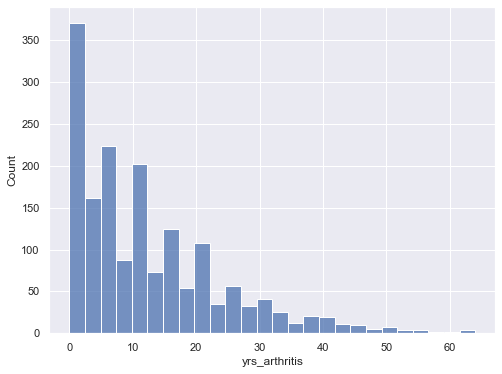

In [29]:
# no negative values, that's good

sns.histplot(arthritis_5['yrs_arthritis'])

In [30]:
# transfer years of arthritis to either osteoarthritis or other_arthritis columns to get continuous variables

arthritis_6 = arthritis_5.copy()
arthritis_6.loc[arthritis_6['osteoarthritis'] == 1, 'osteoarthritis'] = arthritis_6['yrs_arthritis']
arthritis_6.loc[arthritis_6['other_arthritis'] == 1, 'other_arthritis'] = arthritis_6['yrs_arthritis']
arthritis_6


,SEQN,osteoarthritis,other_arthritis,yrs_arthritis
0,93703.00000,0.00000,0.00000,nan
1,93704.00000,0.00000,0.00000,nan
2,93705.00000,0.00000,2.00000,2.00000
3,93706.00000,0.00000,0.00000,nan
4,93707.00000,0.00000,0.00000,nan
...,...,...,...,...
8892,102952.00000,0.00000,0.00000,nan
8893,102953.00000,0.00000,0.00000,nan
8894,102954.00000,0.00000,0.00000,nan
8895,102955.00000,0.00000,0.00000,nan


In [31]:
# drop original years column, rename columnms to indicate a measurement in years
# create final arth_yrs df

arth_yrs = arthritis_6[['SEQN', 'osteoarthritis', 'other_arthritis']]
arth_yrs.rename(columns = {'osteoarthritis': 'yrs_osteoarth', 'other_arthritis': 'yrs_other_arth'}, inplace=True)
arth_yrs


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,SEQN,yrs_osteoarth,yrs_other_arth
0,93703.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000
2,93705.00000,0.00000,2.00000
3,93706.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000
...,...,...,...
8892,102952.00000,0.00000,0.00000
8893,102953.00000,0.00000,0.00000
8894,102954.00000,0.00000,0.00000
8895,102955.00000,0.00000,0.00000


In [32]:
# make a binary arthritis df as well

arth_col = ['yrs_osteoarth', 'yrs_other_arth']

arth_binary = ut.make_binary(arth_yrs, arth_col)
arth_binary.head(200)

,SEQN,osteoarth_binary,other_arth_binary
0,93703.00000,0,0
1,93704.00000,0,0
2,93705.00000,0,1
3,93706.00000,0,0
4,93707.00000,0,0
5,93708.00000,0,0
6,93709.00000,0,1
7,93711.00000,0,0
8,93712.00000,0,0
9,93713.00000,0,1


In [33]:
# check arth_binary against arthritis_5
# it's good that arth_binary has fewer ppl marked with arthritis than arthritis_5
# this means that ppl diagnosed in the past year have been eliminated

print(arthritis_5['osteoarthritis'].value_counts())
print(arth_binary['osteoarth_binary'].value_counts())

0    8186
1     711
Name: osteoarthritis, dtype: int64
0    8211
1     686
Name: osteoarth_binary, dtype: int64


### Create clean circulatory condition dfs - 1 df with continuous and 1 df with binary variables

In [34]:
# clean up circulatory conditions

circ = mcq_j[['SEQN',
                 'MCD180B', # age when told you had heart failure
                 'MCD180C', # age when told you had CAD
                 'MCD180D', # age when told you had angina pectoris
                 'MCD180E', # age when told you had a heart attack
                 'MCD180F' # age when told you had a stroke
                   ]]

In [35]:
# check values of age columns for valid ages

circ_age_columns = ['MCD180B', # age when told you had heart failure
                 'MCD180C', # age when told you had CAD
                 'MCD180D', # age when told you had angina pectoris
                 'MCD180E', # age when told you had a heart attack
                 'MCD180F' # age when told you had a stroke
                   ]

for col in circ_age_columns:
    print(circ[col].value_counts())

# need to remove 99999.00000

80.00000       14
65.00000       11
60.00000       10
63.00000       10
55.00000       10
56.00000        7
69.00000        7
61.00000        7
74.00000        6
50.00000        6
45.00000        6
47.00000        5
59.00000        5
44.00000        5
72.00000        4
78.00000        4
70.00000        4
34.00000        4
73.00000        4
40.00000        4
58.00000        4
30.00000        3
54.00000        3
75.00000        3
68.00000        3
64.00000        3
57.00000        3
76.00000        3
53.00000        3
62.00000        3
16.00000        3
36.00000        3
46.00000        2
42.00000        2
71.00000        2
67.00000        2
52.00000        2
33.00000        2
28.00000        2
35.00000        2
49.00000        2
99999.00000     2
48.00000        1
79.00000        1
38.00000        1
39.00000        1
51.00000        1
18.00000        1
26.00000        1
31.00000        1
29.00000        1
19.00000        1
66.00000        1
Name: MCD180B, dtype: int64
55.00000       18


In [36]:
# replace 99999.00000 with median in all age columns

for col in circ_age_columns:
    circ[col] = ut.replace_with_median(circ[col], 99999.00000)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


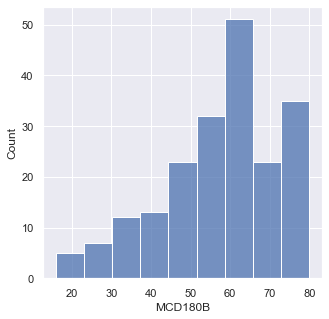

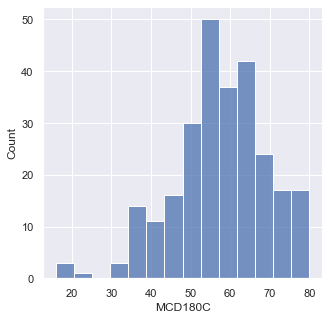

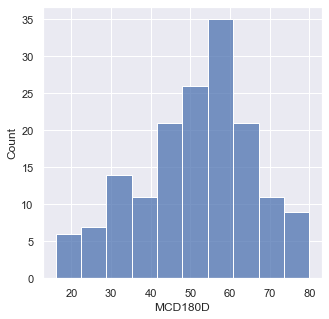

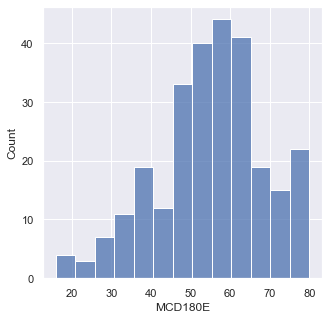

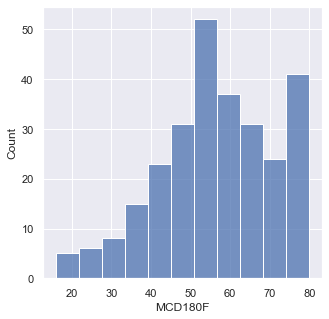

In [37]:
# recheck values in age columns with histograms
# looks good - no 99999.00000

for col in circ_age_columns:
    fig = plt.figure(figsize = (5,5))
    sns.histplot(data=circ, x=col, y=None)
    
# patients over 80 are top-coded as 80

In [38]:
# label heart failure - leading cause of hospitalizations

circ_2 = circ.rename(columns = {'MCD180B': 'heart_failure'})
circ_2

,SEQN,heart_failure,MCD180C,MCD180D,MCD180E,MCD180F
0,93703.00000,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan
2,93705.00000,nan,nan,nan,nan,nan
3,93706.00000,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan
...,...,...,...,...,...,...
8892,102952.00000,nan,nan,nan,nan,nan
8893,102953.00000,nan,nan,nan,nan,nan
8894,102954.00000,nan,nan,nan,nan,nan
8895,102955.00000,nan,nan,nan,nan,nan


In [39]:
# combine other circulatory conditions - use minimum age of diagnosis
# none of these have a "still have" question

other_circ_cond = ['MCD180C', 'MCD180D', 'MCD180E', 'MCD180F']

circ_2['age_oth_cond'] = circ_2[other_circ_cond].min(axis=1)
circ_2

,SEQN,heart_failure,MCD180C,MCD180D,MCD180E,MCD180F,age_oth_cond
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,nan,nan,nan,nan,nan
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...
8892,102952.00000,nan,nan,nan,nan,nan,nan
8893,102953.00000,nan,nan,nan,nan,nan,nan
8894,102954.00000,nan,nan,nan,nan,nan,nan
8895,102955.00000,nan,nan,nan,nan,nan,nan


In [40]:
# drop original other circ condition columns

circ_3 = circ_2.drop(columns = ['MCD180C', 'MCD180D', 'MCD180E', 'MCD180F'])
circ_3

,SEQN,heart_failure,age_oth_cond
0,93703.00000,nan,nan
1,93704.00000,nan,nan
2,93705.00000,nan,nan
3,93706.00000,nan,nan
4,93707.00000,nan,nan
...,...,...,...
8892,102952.00000,nan,nan
8893,102953.00000,nan,nan
8894,102954.00000,nan,nan
8895,102955.00000,nan,nan


In [41]:
# get years since diagnosis

circ_4 = ut.get_years(circ_3, 'heart_failure', 'yrs_heart_fail')
circ_5 = ut.get_years(circ_4, 'age_oth_cond', 'yrs_heart_cond')
circ_5

,SEQN,yrs_heart_fail,yrs_heart_cond
0,93703.00000,nan,nan
1,93704.00000,nan,nan
2,93705.00000,nan,nan
3,93706.00000,nan,nan
4,93707.00000,nan,nan
...,...,...,...
8892,102952.00000,nan,nan
8893,102953.00000,nan,nan
8894,102954.00000,nan,nan
8895,102955.00000,nan,nan


In [42]:
# create final circ_yrs df

circ_yrs = circ_5.fillna(0)
circ_yrs

,SEQN,yrs_heart_fail,yrs_heart_cond
0,93703.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000
2,93705.00000,0.00000,0.00000
3,93706.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000
...,...,...,...
8892,102952.00000,0.00000,0.00000
8893,102953.00000,0.00000,0.00000
8894,102954.00000,0.00000,0.00000
8895,102955.00000,0.00000,0.00000


In [43]:
# make binary circ df

circ_binary = ut.make_binary(circ_yrs, ['yrs_heart_fail', 'yrs_heart_cond'])
circ_binary

,SEQN,heart_fail_binary,heart_cond_binary
0,93703.00000,0,0
1,93704.00000,0,0
2,93705.00000,0,0
3,93706.00000,0,0
4,93707.00000,0,0
...,...,...,...
8892,102952.00000,0,0
8893,102953.00000,0,0
8894,102954.00000,0,0
8895,102955.00000,0,0


### Create clean respiratory condition dfs - 1 df with continuous and 1 df with binary variables

In [44]:
# clean up respiratory conditions

resp = mcq_j[['SEQN',
                'MCD180G', # age when told you had emphysema
                 'MCD180K', # age when told you had chronic bronchitis
                 'MCQ170K', # do you still have chronic bronchitis
                 'MCQ160O', # ever told you had COPD?
                 'MCQ025', # age when first had asthma
                'MCQ035' # do you still have asthma
                ]]

resp.info()

# for asthma and chronic bronc, update data to reflect whether patient still has it
# keep in mind, COPD is unusual because it's "ever told" not "age when"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8897 entries, 0 to 8896
Data columns (total 7 columns):
SEQN       8897 non-null float64
MCD180G    106 non-null float64
MCD180K    395 non-null float64
MCQ170K    395 non-null float64
MCQ160O    5569 non-null float64
MCQ025     1325 non-null float64
MCQ035     1325 non-null float64
dtypes: float64(7)
memory usage: 486.7 KB


In [45]:
# look at ages - need to replace 99999.00000

resp_col = ['MCD180G', 'MCD180K', 'MCQ025']

for col_name in resp_col:
    print(resp[col_name].value_counts().head(200))

60.00000       7
45.00000       7
50.00000       6
40.00000       4
70.00000       4
61.00000       4
67.00000       3
48.00000       3
62.00000       3
76.00000       3
53.00000       3
30.00000       3
99999.00000    3
43.00000       3
68.00000       3
54.00000       2
65.00000       2
59.00000       2
80.00000       2
39.00000       2
32.00000       2
69.00000       2
35.00000       2
58.00000       2
71.00000       2
72.00000       2
55.00000       2
36.00000       2
74.00000       2
66.00000       1
41.00000       1
44.00000       1
16.00000       1
56.00000       1
26.00000       1
28.00000       1
64.00000       1
49.00000       1
27.00000       1
47.00000       1
75.00000       1
42.00000       1
34.00000       1
33.00000       1
51.00000       1
57.00000       1
63.00000       1
52.00000       1
Name: MCD180G, dtype: int64
16.00000       81
99999.00000    18
35.00000       16
40.00000       16
25.00000       15
30.00000       15
50.00000       13
45.00000       12
55.00000    

In [46]:
for col_name in resp_col:
    resp[col_name] = ut.replace_with_median(resp[col_name], 99999.00000)

# recheck value counts

for col_name in resp_col:
    print(resp[col_name].value_counts().head(200))

60.00000    7
45.00000    7
50.00000    6
54.00000    5
40.00000    4
70.00000    4
61.00000    4
67.00000    3
48.00000    3
62.00000    3
76.00000    3
53.00000    3
30.00000    3
68.00000    3
43.00000    3
71.00000    2
55.00000    2
58.00000    2
32.00000    2
35.00000    2
65.00000    2
69.00000    2
39.00000    2
72.00000    2
36.00000    2
80.00000    2
59.00000    2
74.00000    2
16.00000    1
56.00000    1
44.00000    1
28.00000    1
64.00000    1
66.00000    1
41.00000    1
47.00000    1
75.00000    1
34.00000    1
33.00000    1
51.00000    1
57.00000    1
63.00000    1
49.00000    1
42.00000    1
52.00000    1
26.00000    1
27.00000    1
Name: MCD180G, dtype: int64
16.00000    81
34.00000    21
40.00000    16
35.00000    16
30.00000    15
25.00000    15
50.00000    13
45.00000    12
55.00000    11
20.00000    10
60.00000     9
22.00000     8
27.00000     8
32.00000     8
70.00000     7
42.00000     6
17.00000     6
80.00000     6
65.00000     6
19.00000     6
75.00000     5

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


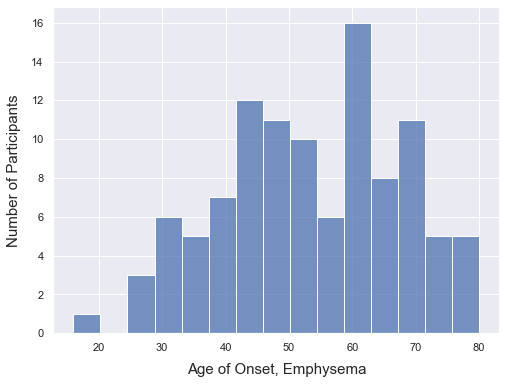

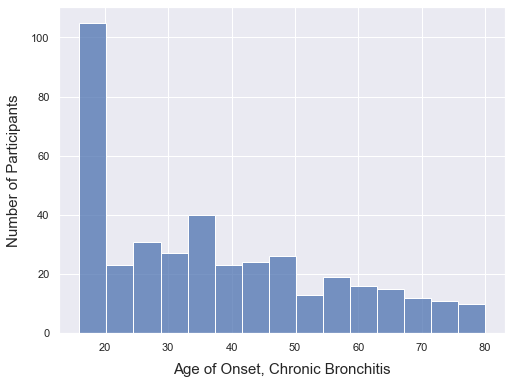

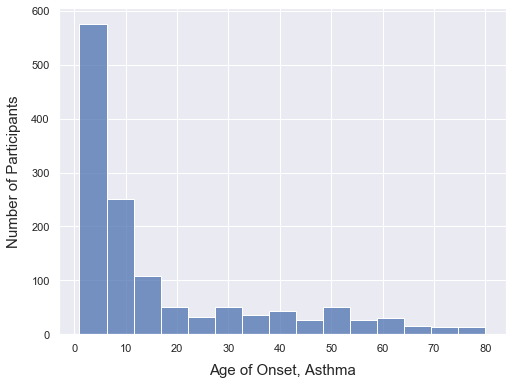

In [47]:
# check histograms
# no negative values
# for chronic bronchitis, 16 and younger is coded as 16

labels = ['Age of Onset, Emphysema',
         'Age of Onset, Chronic Bronchitis',
         'Age of Onset, Asthma']

for i, col_name in enumerate(resp_col):
    plt.figure(i)
    sns.histplot(resp[col_name], bins=15)
    plt.xlabel(labels[i], fontsize=15, labelpad=10)
    plt.ylabel('Number of Participants', fontsize=15, labelpad=10)
    

In [48]:
resp

,SEQN,MCD180G,MCD180K,MCQ170K,MCQ160O,MCQ025,MCQ035
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,nan,nan,2.00000,10.00000,2.00000
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...
8892,102952.00000,nan,nan,nan,2.00000,nan,nan
8893,102953.00000,nan,nan,nan,2.00000,42.00000,1.00000
8894,102954.00000,nan,nan,nan,2.00000,nan,nan
8895,102955.00000,nan,nan,nan,nan,nan,nan


In [49]:
# look at values for yes/no questions - ever had COPD, still have asthma, and still have chronic bronchitis

cols_to_edit = ['MCQ160O', 'MCQ035', 'MCQ170K']
for col in cols_to_edit:
    print(resp[col].value_counts())

# change to 1 and 0 for binary instead of 1 and 2
# also change 9 ('don't know') to 0
# also change 7 ('refused') to 0 --> just 1 value for 'Still have asthma?'
    
for col in cols_to_edit:
    resp.loc[resp[col].isin([2, 9, 7]), col] = 0

#check

print('\n', 'Updated values:', '\n')
for col in cols_to_edit:
    print(resp[col].value_counts())

2.00000    5267
1.00000     293
9.00000       9
Name: MCQ160O, dtype: int64
1.00000    825
2.00000    471
9.00000     28
7.00000      1
Name: MCQ035, dtype: int64
2.00000    209
1.00000    173
9.00000     13
Name: MCQ170K, dtype: int64

 Updated values: 

0.00000    5276
1.00000     293
Name: MCQ160O, dtype: int64
1.00000    825
0.00000    500
Name: MCQ035, dtype: int64
0.00000    222
1.00000    173
Name: MCQ170K, dtype: int64


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [50]:
# get yrs with emphysema and chronic bronchitis

resp_2 = ut.get_years(resp, 'MCD180G', 'yrs_emphysema')
resp_3 = ut.get_years(resp_2, 'MCD180K', 'yrs_chron_bronc')
resp_3.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ025,MCQ035,yrs_emphysema,yrs_chron_bronc
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,10.00000,0.00000,nan,nan
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,5.00000,0.00000,nan,nan
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [51]:
# update yrs_chron_bronc to reflect whether person still has it

resp_3['yrs_chron_bronc'] = np.where(resp_3['MCQ170K'] == 0, 0, resp_3['yrs_chron_bronc'])
resp_3.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ025,MCQ035,yrs_emphysema,yrs_chron_bronc
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,10.00000,0.00000,nan,nan
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,5.00000,0.00000,nan,nan
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [52]:
# get years with asthma

resp_4 = ut.get_years(resp_3, 'MCQ025', 'yrs_asthma')
resp_4.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ035,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,0.00000,nan,nan,56.00000
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,0.00000,nan,nan,13.00000
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [53]:
# update yrs_asthma to reflect whether person still has it

resp_4['yrs_asthma'] = np.where(resp_4['MCQ035'] == 0, 0, resp_4['yrs_asthma'])
resp_4.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ035,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,0.00000,nan,nan,0.00000
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,0.00000,nan,nan,0.00000
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [54]:
# drop original columns

resp_5 = resp_4.drop(columns = ['MCQ170K', 'MCQ035'])
resp_5

,SEQN,MCQ160O,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan
2,93705.00000,0.00000,nan,nan,0.00000
3,93706.00000,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan
...,...,...,...,...,...
8892,102952.00000,0.00000,nan,nan,nan
8893,102953.00000,0.00000,nan,nan,0.00000
8894,102954.00000,0.00000,nan,nan,nan
8895,102955.00000,nan,nan,nan,nan


In [55]:
# define final resp_yrs df

resp_yrs = resp_5.rename(columns = {'MCQ160O': 'ever_had_COPD'}).fillna(0)
resp_yrs

,SEQN,ever_had_COPD,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,0.00000,0.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000,0.00000,0.00000
2,93705.00000,0.00000,0.00000,0.00000,0.00000
3,93706.00000,0.00000,0.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...
8892,102952.00000,0.00000,0.00000,0.00000,0.00000
8893,102953.00000,0.00000,0.00000,0.00000,0.00000
8894,102954.00000,0.00000,0.00000,0.00000,0.00000
8895,102955.00000,0.00000,0.00000,0.00000,0.00000


In [56]:
# create resp_binary df

resp_binary = ut.make_binary(resp_yrs, ['yrs_emphysema', 'yrs_chron_bronc', 'yrs_asthma'])
resp_binary

,SEQN,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary
0,93703.00000,0.00000,0,0,0
1,93704.00000,0.00000,0,0,0
2,93705.00000,0.00000,0,0,0
3,93706.00000,0.00000,0,0,0
4,93707.00000,0.00000,0,0,0
...,...,...,...,...,...
8892,102952.00000,0.00000,0,0,0
8893,102953.00000,0.00000,0,0,0
8894,102954.00000,0.00000,0,0,0
8895,102955.00000,0.00000,0,0,0


### Create clean diabetes dfs - 1 df with continuous and 1 df with binary variables

In [57]:
# clean up diabetes data

diabetes = diq_j[['SEQN',
                 'DID040', # Age when first told you had diabetes
                 'DID060', # How long taking insulin
                 'DIQ060U' # Unit of measure (month/year) - for how long taking insulin
                ]].merge(age, how='left', on='SEQN')

diabetes

,SEQN,DID040,DID060,DIQ060U,RIDAGEYR
0,93703.00000,nan,nan,nan,2.00000
1,93704.00000,nan,nan,nan,2.00000
2,93705.00000,nan,nan,nan,66.00000
3,93706.00000,nan,nan,nan,18.00000
4,93707.00000,nan,nan,nan,13.00000
...,...,...,...,...,...
8892,102952.00000,nan,nan,nan,70.00000
8893,102953.00000,nan,nan,nan,42.00000
8894,102954.00000,nan,nan,nan,41.00000
8895,102955.00000,nan,nan,nan,14.00000


In [58]:
diabetes['DID040'].value_counts()

# in this data 'I don't know' is 999.00000
# and 'less than 1 year 'is 666.00000 - meaning person has been diabetic their whole life for DID040


50.00000     79
40.00000     48
45.00000     45
55.00000     45
60.00000     42
58.00000     31
59.00000     23
62.00000     23
30.00000     22
48.00000     21
65.00000     20
54.00000     20
52.00000     20
53.00000     19
47.00000     19
46.00000     18
35.00000     18
42.00000     17
38.00000     17
57.00000     17
56.00000     16
68.00000     16
70.00000     15
61.00000     14
63.00000     13
64.00000     11
80.00000     11
37.00000     11
999.00000    10
41.00000     10
49.00000      9
51.00000      8
66.00000      8
32.00000      8
33.00000      8
67.00000      7
69.00000      7
73.00000      7
25.00000      7
71.00000      6
78.00000      6
39.00000      6
43.00000      6
34.00000      6
28.00000      6
36.00000      6
44.00000      6
29.00000      5
72.00000      5
75.00000      5
76.00000      5
21.00000      4
22.00000      4
26.00000      4
20.00000      3
23.00000      3
9.00000       3
17.00000      3
18.00000      3
12.00000      3
77.00000      3
74.00000      3
16.00000

In [59]:
# replace 666.00000 with respondent's age (since they've had it their whole life)

diabetes.loc[diabetes['DID040'] == 666.00000, 'DID040'] = diabetes['RIDAGEYR']

In [60]:
diabetes['DID040'].value_counts()

50.00000     79
40.00000     48
45.00000     45
55.00000     45
60.00000     42
58.00000     31
59.00000     23
62.00000     23
30.00000     22
48.00000     21
65.00000     20
54.00000     20
52.00000     20
53.00000     19
47.00000     19
46.00000     18
35.00000     18
57.00000     17
42.00000     17
38.00000     17
68.00000     16
56.00000     16
70.00000     15
61.00000     14
63.00000     13
37.00000     11
80.00000     11
64.00000     11
41.00000     10
999.00000    10
49.00000      9
32.00000      8
51.00000      8
66.00000      8
33.00000      8
73.00000      7
67.00000      7
69.00000      7
25.00000      7
43.00000      6
34.00000      6
28.00000      6
71.00000      6
36.00000      6
78.00000      6
39.00000      6
44.00000      6
76.00000      5
72.00000      5
75.00000      5
29.00000      5
26.00000      4
21.00000      4
22.00000      4
16.00000      4
20.00000      3
9.00000       3
18.00000      3
12.00000      3
17.00000      3
23.00000      3
77.00000      3
74.00000

In [61]:
# for DID060 (how long taking insulin), '666.00000' means 'less than 1 month' --> replace with 0

diabetes.loc[diabetes['DID060'] == 666.00000, 'DID060'] = 0


In [62]:
# replace 999.00000 with median age value for age at diagnosis and how long taking insulin

diabetes['DID040'] = ut.replace_with_median(diabetes['DID040'], 999.00000)
diabetes['DID060'] = ut.replace_with_median(diabetes['DID060'], 999.00000)

In [63]:
# drop age column so get_years function doesn't produce a duplicate column
diabetes_2 = diabetes.drop(columns = 'RIDAGEYR')

# get years since diabetes diagnosis
diabetes_3 = ut.get_years(diabetes_2, 'DID040', 'yrs_diabetes')

diabetes_3.head(20)

,SEQN,DID060,DIQ060U,yrs_diabetes
0,93703.00000,nan,nan,nan
1,93704.00000,nan,nan,nan
2,93705.00000,nan,nan,nan
3,93706.00000,nan,nan,nan
4,93707.00000,nan,nan,nan
5,93708.00000,nan,nan,nan
6,93709.00000,nan,nan,nan
7,93711.00000,nan,nan,nan
8,93712.00000,nan,nan,nan
9,93713.00000,nan,nan,nan


In [64]:
# check one example

diabetes.iloc[10]

SEQN       93714.00000
DID040        35.00000
DID060        11.00000
DIQ060U        2.00000
RIDAGEYR      54.00000
Name: 10, dtype: float64

In [65]:
# DIQ060U - Unit of measure (month/year)
# Variable Name:DIQ060USAS Label:Unit of measure (month/year)
# Code or Value
# 1	Months
# 2	Years
# .	Missing

# where unit of measurement = 1 (months), divide length of time by 12 to get years

diabetes_4 = diabetes_3.copy()
diabetes_4.loc[diabetes_4['DIQ060U'] == 1, 'DID060'] = diabetes_4['DID060'] / 12
diabetes_4.head(20)

,SEQN,DID060,DIQ060U,yrs_diabetes
0,93703.00000,nan,nan,nan
1,93704.00000,nan,nan,nan
2,93705.00000,nan,nan,nan
3,93706.00000,nan,nan,nan
4,93707.00000,nan,nan,nan
5,93708.00000,nan,nan,nan
6,93709.00000,nan,nan,nan
7,93711.00000,nan,nan,nan
8,93712.00000,nan,nan,nan
9,93713.00000,nan,nan,nan


In [66]:
# create final dm_yrs df

dm_yrs = diabetes_4[['SEQN', 'yrs_diabetes', 'DID060']].fillna(0)
dm_yrs.rename(columns = {'DID060': 'yrs_taking_ins'}, inplace=True)
dm_yrs.head(20)

,SEQN,yrs_diabetes,yrs_taking_ins
0,93703.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000
2,93705.00000,0.00000,0.00000
3,93706.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000
5,93708.00000,0.00000,0.00000
6,93709.00000,0.00000,0.00000
7,93711.00000,0.00000,0.00000
8,93712.00000,0.00000,0.00000
9,93713.00000,0.00000,0.00000


In [67]:
# make dm_binary df

dm_binary = ut.make_binary(dm_yrs, ['yrs_diabetes', 'yrs_taking_ins'])
dm_binary.head(20)

,SEQN,diabetes_binary,taking_ins_binary
0,93703.00000,0,0
1,93704.00000,0,0
2,93705.00000,0,0
3,93706.00000,0,0
4,93707.00000,0,0
5,93708.00000,0,0
6,93709.00000,0,0
7,93711.00000,0,0
8,93712.00000,0,0
9,93713.00000,0,0


In [68]:
# why is this person taking insulin but doesn't have a diabetes age when diagnosed?
# looks like there are a few SEQNs who have diabetes but have nan for age when diagnosed - just 23
# for now, leave these SEQNs as no diabetes

diq_j.loc[diq_j['SEQN'] == 93869.00000]

,SEQN,DIQ010,DID040,DIQ160,DIQ170,DIQ172,DIQ175A,DIQ175B,DIQ175C,DIQ175D,DIQ175E,DIQ175F,DIQ175G,DIQ175H,DIQ175I,DIQ175J,DIQ175K,DIQ175L,DIQ175M,DIQ175N,DIQ175O,DIQ175P,DIQ175Q,DIQ175R,DIQ175S,DIQ175T,DIQ175U,DIQ175V,DIQ175W,DIQ175X,DIQ180,DIQ050,DID060,DIQ060U,DIQ070,DIQ230,DIQ240,DID250,DID260,DIQ260U,DIQ275,DIQ280,DIQ291,DIQ300S,DIQ300D,DID310S,DID310D,DID320,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080
161,93869.00000,1.00000,80.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00000,2.00000,2.00000,1.00000,1.00000,1.00000,2.00000,0.00000,nan,1.00000,2.30000,99.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,1.00000,1.00000,1.00000,2.00000


### Create DataFrame with all continuous variables: Arthritis, Circulatory, Respiratory, Diabetes, and Target

In [69]:
dfs_to_merge = [arth_yrs, circ_yrs, resp_yrs, dm_yrs, target]

yrs_df = age.copy()

for df in dfs_to_merge:
    yrs_df = yrs_df.merge(df, how='left', on='SEQN')

yrs_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9254 entries, 0 to 9253
Data columns (total 13 columns):
SEQN               9254 non-null float64
RIDAGEYR           9254 non-null float64
yrs_osteoarth      8897 non-null float64
yrs_other_arth     8897 non-null float64
yrs_heart_fail     8897 non-null float64
yrs_heart_cond     8897 non-null float64
ever_had_COPD      8897 non-null float64
yrs_emphysema      8897 non-null float64
yrs_chron_bronc    8897 non-null float64
yrs_asthma         8897 non-null float64
yrs_diabetes       8897 non-null float64
yrs_taking_ins     8897 non-null float64
HUQ071             9251 non-null float64
dtypes: float64(13)
memory usage: 1012.2 KB


In [70]:
# check examples of SEQNs with null values for all medical conditions

demo_j.loc[demo_j['SEQN'] == 93710.00000]

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
7,93710.00000,10.00000,2.00000,2.00000,0.00000,11.00000,3.00000,3.00000,2.00000,13.00000,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,nan,nan,nan,nan,3.00000,3.00000,1.00000,0.00000,0.00000,1.00000,2.00000,3.00000,1.00000,3.00000,16418.29842,16848.02012,1.00000,134.00000,15.00000,15.00000,4.90000


In [71]:
# the people with nulls in all the health questions are babies - remove them

yrs_df_2 = yrs_df.loc[~yrs_df['yrs_osteoarth'].isna()]
yrs_df_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8897 entries, 0 to 9253
Data columns (total 13 columns):
SEQN               8897 non-null float64
RIDAGEYR           8897 non-null float64
yrs_osteoarth      8897 non-null float64
yrs_other_arth     8897 non-null float64
yrs_heart_fail     8897 non-null float64
yrs_heart_cond     8897 non-null float64
ever_had_COPD      8897 non-null float64
yrs_emphysema      8897 non-null float64
yrs_chron_bronc    8897 non-null float64
yrs_asthma         8897 non-null float64
yrs_diabetes       8897 non-null float64
yrs_taking_ins     8897 non-null float64
HUQ071             8894 non-null float64
dtypes: float64(13)
memory usage: 973.1 KB


In [72]:
# we need the target!  remove rows where target is null

yrs_df_3 = yrs_df_2.loc[~yrs_df_2['HUQ071'].isna()].set_index('SEQN')
yrs_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8894 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
RIDAGEYR           8894 non-null float64
yrs_osteoarth      8894 non-null float64
yrs_other_arth     8894 non-null float64
yrs_heart_fail     8894 non-null float64
yrs_heart_cond     8894 non-null float64
ever_had_COPD      8894 non-null float64
yrs_emphysema      8894 non-null float64
yrs_chron_bronc    8894 non-null float64
yrs_asthma         8894 non-null float64
yrs_diabetes       8894 non-null float64
yrs_taking_ins     8894 non-null float64
HUQ071             8894 non-null float64
dtypes: float64(12)
memory usage: 903.3 KB


In [73]:
# minority class is just 8.5 %

yrs_df_3['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

In [74]:
# export continuous variables df for modeling

yrs_df_3.to_csv('data/yrs_df')

### Create DataFrame with all binary variables: Arthritis, Circulatory, Respiratory, Diabetes, and Target

In [75]:
# try binary

dfs_to_merge = [arth_binary, circ_binary, resp_binary, dm_binary, target]

binary_df = age.copy()

for df in dfs_to_merge:
    binary_df = binary_df.merge(df, how='left', on='SEQN')

binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9254 entries, 0 to 9253
Data columns (total 13 columns):
SEQN                  9254 non-null float64
RIDAGEYR              9254 non-null float64
osteoarth_binary      8897 non-null float64
other_arth_binary     8897 non-null float64
heart_fail_binary     8897 non-null float64
heart_cond_binary     8897 non-null float64
ever_had_COPD         8897 non-null float64
emphysema_binary      8897 non-null float64
chron_bronc_binary    8897 non-null float64
asthma_binary         8897 non-null float64
diabetes_binary       8897 non-null float64
taking_ins_binary     8897 non-null float64
HUQ071                9251 non-null float64
dtypes: float64(13)
memory usage: 1012.2 KB


In [76]:
# the people with nulls in all the health questions are babies - remove them

binary_df = binary_df.loc[~binary_df['osteoarth_binary'].isna()]
binary_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8897 entries, 0 to 9253
Data columns (total 13 columns):
SEQN                  8897 non-null float64
RIDAGEYR              8897 non-null float64
osteoarth_binary      8897 non-null float64
other_arth_binary     8897 non-null float64
heart_fail_binary     8897 non-null float64
heart_cond_binary     8897 non-null float64
ever_had_COPD         8897 non-null float64
emphysema_binary      8897 non-null float64
chron_bronc_binary    8897 non-null float64
asthma_binary         8897 non-null float64
diabetes_binary       8897 non-null float64
taking_ins_binary     8897 non-null float64
HUQ071                8894 non-null float64
dtypes: float64(13)
memory usage: 973.1 KB


In [77]:
# we need the target!  remove rows where target is null

binary_df_2 = binary_df.loc[~yrs_df_2['HUQ071'].isna()].set_index('SEQN')
binary_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8894 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
RIDAGEYR              8894 non-null float64
osteoarth_binary      8894 non-null float64
other_arth_binary     8894 non-null float64
heart_fail_binary     8894 non-null float64
heart_cond_binary     8894 non-null float64
ever_had_COPD         8894 non-null float64
emphysema_binary      8894 non-null float64
chron_bronc_binary    8894 non-null float64
asthma_binary         8894 non-null float64
diabetes_binary       8894 non-null float64
taking_ins_binary     8894 non-null float64
HUQ071                8894 non-null float64
dtypes: float64(12)
memory usage: 903.3 KB


In [78]:
# minority class is just 8.5 %

binary_df_2['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

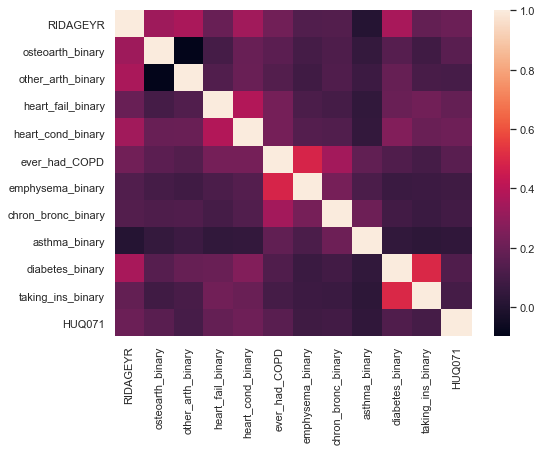

In [79]:
# explore correlations and multicolinearity

corr = binary_df_2.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# strongest, interestingly, is COPD and emphesyma - also around 50%
# nothing is strongly correlated with hospitalization (HUQ071)

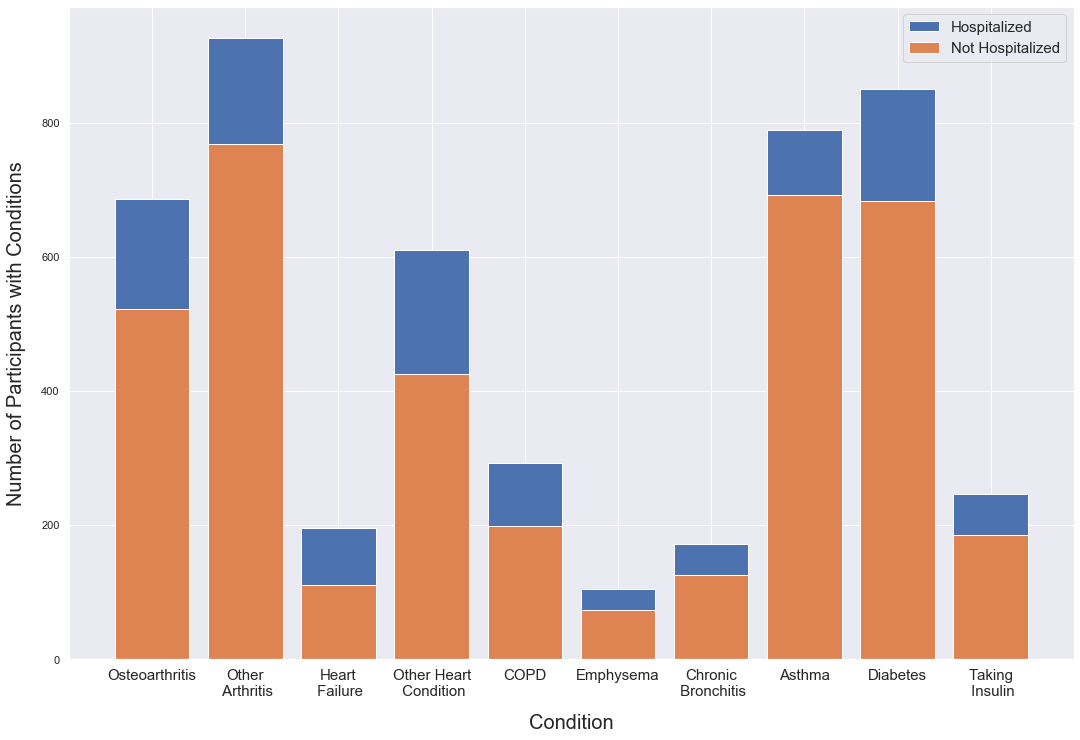

In [159]:
# plot bar chart to showcase odds ratios of variables and hospitalization

fig, ax = plt.subplots(figsize=(18,12))

# create list of columns to plot
col_list = list(binary_df_2.columns)[1:11]

# create lists for number of people with each condition who were and were not hospitalized
yes_list = []
no_list = []

for col in col_list:
    yes = binary_df_2.loc[(binary_df_2[col] == 1) & (binary_df_2['HUQ071'] == 1), 'HUQ071'].count()
    no = binary_df_2.loc[(binary_df_2[col] == 1) & (binary_df_2['HUQ071'] == 0), 'HUQ071'].count()
    
    yes_list.append(yes)
    no_list.append(no)

ax.bar(x=col_list, height=yes_list, label='Hospitalized', bottom=no_list)
ax.bar(x=col_list, height=no_list, label='Not Hospitalized')

ax.set_xticklabels(['Osteoarthritis', 
                    'Other\n Arthritis', 
                    'Heart\n Failure', 
                    'Other Heart\n Condition', 
                    'COPD', 'Emphysema', 
                    'Chronic\n Bronchitis', 
                    'Asthma', 
                    'Diabetes', 
                    'Taking\n Insulin'],
                  fontsize=15)

ax.set_xlabel('Condition', fontsize=20, labelpad=15)
ax.set_ylabel('Number of Participants with Conditions', fontsize=20, labelpad=15)

ax.legend(fontsize=15)

In [160]:
col_list

['osteoarth_binary',
 'other_arth_binary',
 'heart_fail_binary',
 'heart_cond_binary',
 'ever_had_COPD',
 'emphysema_binary',
 'chron_bronc_binary',
 'asthma_binary',
 'diabetes_binary',
 'taking_ins_binary']

In [161]:
yes_list

[163, 159, 85, 185, 94, 31, 46, 97, 168, 62]

In [162]:
no_list

[523, 768, 111, 426, 199, 74, 125, 693, 683, 185]

In [163]:
len(binary_df_2)

8894

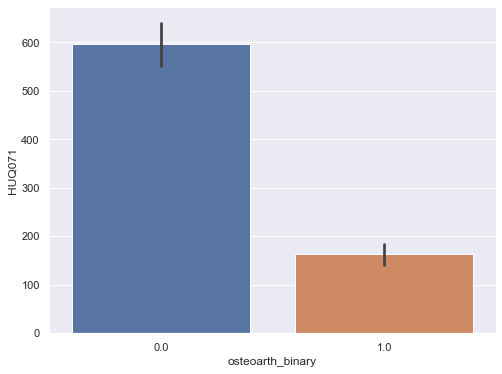

In [105]:
sns.barplot(x='osteoarth_binary', y='HUQ071', data=binary_df_2, estimator=sum)

In [ ]:
# export binary variables df for modeling

binary_df_2.to_csv('data/binary_df')

## Data Cleaning - Exclusion of Hospitalizations for Childbirth

Since this analysis does not focus on predicting hospitalizations for childbirth, which are predictable through other methods, I excluded these hospitalizations from the target. Patients who gave birth within the past 12 months had one hospitalization subtracted from their total number of hospitalizations during the past year.

In [ ]:
# explore age variable vs target, for possible classification into buckets

age_to_plot = binary_df_2[['RIDAGEYR','HUQ071']]
age_to_plot

In [ ]:
# box and whiskers plot

sns.catplot(x="HUQ071", y="RIDAGEYR", data=binary_df_2, kind='box')

In [ ]:
# swarm plot
# looks like there is a bulge around the childbearing years
# try to eliminate hospitalizations for childbirth, and limit this project to non-birth hospitalizations

sns.catplot(x="HUQ071", y="RIDAGEYR", data=binary_df_2, kind='swarm')

In [ ]:
# use this question to figure out who had babies in the past 12 months:
# RHQ197 - How many months ago have baby?
# then update hospitalizations to reflect only non-birth hospitalizations
# create a df of non-birth hospitalizations to update target

babies_this_year = rhq_j[['SEQN', 'RHQ197']]
babies_this_year = babies_this_year.loc[~babies_this_year['RHQ197'].isna()]
babies_this_year

In [ ]:
# join target
babies_target = babies_this_year.merge(target, how='left', on='SEQN')
babies_target

# most people who had babies within past 12 months are marked as 1 - had a hospital stay
# not all are, possibly due to differences in how ppl responded to the question

In [ ]:
# how many in this group were hospitalized?

babies_target['HUQ071'].sum()

In [ ]:
# also merge in count of total hospitalizations
# HUD080
# How many different times did {you/SP} stay in any hospital overnight or longer {during the past 12 months}? 

babies_target_2 = babies_target.merge(huq_j[['SEQN', 'HUD080']], how='left', on='SEQN')
babies_target_2.fillna(0, inplace=True)
babies_target_2


In [ ]:
# some ppl who delivered babies in the past year were in the hospital more than once

# create a new column to get non-birth hospitalizations
babies_target_2['non_birth_hosp'] = babies_target_2['HUD080']

# remove one hospitalization from the count for ppl who delivered babies during past 12 months

babies_target_3 = babies_target_2.copy()
babies_target_3.loc[(babies_target_3['RHQ197'] <= 12) &
                    (babies_target_3['HUQ071'] != 0), 
                    'non_birth_hosp'] = babies_target_3['HUD080'] - 1
babies_target_3

In [ ]:
# view new column distribution
# most of these women now have 0 hospitalizations

sns.histplot(babies_target_3['non_birth_hosp'])

In [ ]:
# make a binary column for non-birth hospitalizations

babies_target_3['non_birth_hosp_binary'] = np.where(babies_target_3['non_birth_hosp'] > 0, 1, 0)
babies_target_3

In [ ]:
# how many in this group were hospitalized?
# only 16 vs 61 before birth hospitaliations were eliminiated

babies_target_3['non_birth_hosp_binary'].sum()

In [ ]:
babies_target_final = babies_target_3[['SEQN', 'non_birth_hosp_binary']]
babies_target_final

In [ ]:
binary_df_25 = binary_df_2.merge(babies_target_final, how='left', on='SEQN')
binary_df_25

In [ ]:
# create a new column showing only non-birth hospitalizations

binary_df_25['updated_hosp'] = np.where(~binary_df_25['non_birth_hosp_binary'].isnull(), 
                                      binary_df_25['non_birth_hosp_binary'],
                                      binary_df_25['HUQ071'])

In [ ]:
# compare counts of original and updated target columns
# 45 birth hospitalizations were eliminated

print(
     binary_df_25['HUQ071'].sum(),
     binary_df_25['updated_hosp'].sum())

In [ ]:
binary_df_26 = binary_df_25.drop(columns = ['HUQ071','non_birth_hosp_binary'])
binary_df_26.set_index('SEQN', inplace=True)
binary_df_26.to_csv('data/binary_df_2')

In [ ]:
sns.catplot(x="updated_hosp", y="RIDAGEYR", data=binary_df_26, kind='swarm')

In [ ]:
sns.catplot(x="updated_hosp", y="RIDAGEYR", data=binary_df_26, kind='box')

In [ ]:
# add race

# RIDRETH3 - Race/Hispanic origin w/ NH Asian
# Variable Name:RIDRETH3SAS Label:Race/Hispanic origin w/ NH AsianEnglish Text:Recode of reported race and Hispanic origin information, with Non-Hispanic Asian CategoryTarget:Both males and females 0 YEARS - 150 YEARS
# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 1	Mexican American	1367	1367	
# 2	Other Hispanic	820	2187	
# 3	Non-Hispanic White	3150	5337	
# 4	Non-Hispanic Black	2115	7452	
# 6	Non-Hispanic Asian	1168	8620	
# 7	Other Race - Including Multi-Racial	634	9254	
# .	Missing	0	9254	

race = demo_j[['SEQN', 'RIDRETH3']]
race_2 = pd.get_dummies(race, columns=['RIDRETH3'])
race_3 = race_2.drop(columns = ['RIDRETH3_7.0'])
race_3.head()

In [ ]:
race_3.rename(columns = {'RIDRETH3_1.0': 'Mexican American',
                        'RIDRETH3_2.0': 'Other Hispanic',
                        'RIDRETH3_3.0': 'Non-Hispanic White',
                        'RIDRETH3_4.0': 'Non-Hispanic Black',
                        'RIDRETH3_6.0': 'Non-Hispanic Asian'},
             inplace = True)
race_3

In [ ]:
binary_df_3 = binary_df_26.merge(race_3, how='left', on='SEQN').set_index('SEQN')
binary_df_3.head(200)

In [ ]:
binary_df_3.to_csv('data/binary_df_3')

In [ ]:
# explore prescription drug use table

rxq_rx_j.head(200)

In [ ]:
rxq_rx_j['SEQN'].nunique()

In [ ]:
rxq_rx_j.duplicated().sum()

# looks like there are a few true duplicate lines in the data

In [ ]:
# view duplicates
# looks like data entry errors - eliminate duplicates

dups = rxq_rx_j.loc[rxq_rx_j.duplicated(keep = False) == True].sort_values(by=['SEQN'], ascending=True).head(200)
dups

In [ ]:
# eliminate duplicates

rx_df = rxq_rx_j.drop_duplicates()

In [ ]:
# create df showing just rx and days, to create a table of how many rx per patient
# eliminate 9 (refuse to answer) and 7 (don't remember)

rx_df = rx_df[['SEQN','RXDDRUG','RXDDAYS']].loc[rx_df['RXDUSE'].isin([1,2])]

In [ ]:
rx_df

In [ ]:
rx_df['SEQN'].nunique()

In [ ]:
# still some duplicates, why?

rx_df.duplicated().sum()

In [ ]:
# view duplicates

dups = rx_df.loc[rx_df.duplicated(keep = False) == True].sort_values(by=['SEQN'], ascending=True).head(200)
dups

In [ ]:
# view SEQNs in original data

rxq_rx_j.loc[rxq_rx_j['SEQN'] == 102775.00000]

# I see, drugs are the same but diagnoses are different
# or RXQSEEN is different (whether interviewer saw the rx)

# looks like data entry errors - eliminate these as well, since we're just looking at counting drugs per patient

In [ ]:
rx_df.drop_duplicates(inplace=True)

In [ ]:
# recheck duplicates

rx_df.duplicated().sum()

In [ ]:
# mark meds taken greater than 365 as 1

rx_df.loc[rx_df['RXDDAYS'] >= 365, 'rx_one_year_plus'] = 1
rx_df

In [ ]:
# now need to look at same drug with different numbers of days and keep longer days

rx_df.loc[rx_df[['SEQN','RXDDRUG']].duplicated(keep = False) == True].sort_values(by=['SEQN', 'RXDDRUG', 'RXDDAYS'], ascending=True).head(200)


In [ ]:
# drop duplicates with same SEQN and diagnosis - keep row with greatest days

rx_df.drop_duplicates(subset=['SEQN','RXDDRUG'], keep='last', inplace=True)

In [ ]:
rx_df

In [ ]:
# number of unique patients has not changed

rx_df['SEQN'].nunique()

In [ ]:
rx_df_2 = rx_df.drop(columns = ['RXDDAYS', 'RXDDRUG']).fillna(0)
rx_df_2.head(200)

In [ ]:
# get number of prescriptions per patient

rx_counts = rx_df_2.groupby(['SEQN']).sum()
rx_counts.rename(columns = {'rx_one_year_plus': 'num_rx'}, inplace=True)
rx_counts.head(200)

In [ ]:
len(rx_counts)

In [ ]:
binary_df_4 = binary_df_3.merge(rx_counts, how='left', on='SEQN').fillna(0)
binary_df_4.head(200)

In [ ]:
binary_df_4.to_csv('data/binary_df_4')

In [ ]:
# get patients who primary diagnosis for at least one drug is unknown

unknown_rx_dx = rxq_rx_j.loc[rxq_rx_j['RXDRSC1'].isin(['99999', '55555'])]
unknown_rx_dx

In [ ]:
unk_rx_dx_unique_pts = unknown_rx_dx['SEQN'].unique()
len(unk_rx_dx_unique_pts)

In [ ]:
unk_rx_dx_unique_pts = pd.DataFrame(unk_rx_dx_unique_pts)
unk_rx_dx_unique_pts['unknown_dx'] = 1
unk_rx_dx_unique_pts.rename(columns = {0: 'SEQN'}, inplace=True)
unk_rx_dx_unique_pts

In [ ]:
binary_df_5 = binary_df_4.merge(unk_rx_dx_unique_pts, how='left', on='SEQN').fillna(0)
binary_df_5.head()

In [ ]:
binary_df_5.set_index('SEQN', inplace=True)
binary_df_5.to_csv('data/binary_df_5')

In [ ]:
# engineer age - see if buckets produce better outcome

age_2 = age.copy()
age_2

In [ ]:
age_2['agemap'] = age_2['RIDAGEYR'].map(lambda x: 'age_0-5' if x < 5
                                    else 'age_6-17' if x < 17
                                   else 'age_18-49' if x < 50
                                    else 'age_50-59' if x < 60
                                    else 'age_60-69' if x < 70
                                   else 'age_70+')

age_2

In [ ]:
age_buckets = pd.get_dummies(age_2['agemap'])
age_buckets

In [ ]:
# drop one column to reduce features

age_3 = age_2.join(age_buckets).drop(columns = ['age_6-17'])
age_3

In [ ]:
age_4 = age_3.drop(columns = ['RIDAGEYR', 'agemap'])
age_4

In [ ]:
binary_df_6 = binary_df_5.merge(age_4, how='left', on='SEQN').drop(columns = 'RIDAGEYR')
binary_df_6.set_index('SEQN', inplace=True)
binary_df_6.to_csv('data/binary_df_6')

In [ ]:
# add liver conditions as a features

liver = mcq_j[['SEQN',
       'MCQ170L', # do you still have a liver condition
       'MCD180L']] #  Age when told you had a liver condition

liver


In [ ]:
liver['MCQ170L'].value_counts()

# 1 - yes
# 2 - no
# 9 - don't know


In [ ]:
liver['MCD180L'].value_counts()

# need to remove 99999.00000

In [ ]:
liver['MCD180L'] = ut.replace_with_median(liver['MCD180L'], 99999.00000)
liver['MCD180L'].value_counts()

In [ ]:
# get years with liver condition
liver_2 = ut.get_years(liver, 'MCD180L', 'yrs_liver')
liver_2

In [ ]:
# create make yrs_liver binary

liver_3 = ut.make_binary(liver_2, ['yrs_liver'])
liver_3.head(200)

In [ ]:
# update binary column to only reflect 1 if 'Do you still have a liver condition' = 1
liver_3['liver_binary'] = np.where(liver_3['MCQ170L'] == 1, liver_3['liver_binary'], 0)
liver_3.head(200)

In [ ]:
liver_4 = liver_3[['SEQN', 'liver_binary']]
liver_4

In [ ]:
binary_df_7 = binary_df_6.merge(liver_4, how='left', on='SEQN').set_index('SEQN')
binary_df_7.to_csv('data/binary_df_7')

In [ ]:
mcq_j


In [ ]:
cancer = mcq_j[['SEQN',
               'MCD240A', # Age 1st cancer (MCQ230a) diagnosed
                 'MCD240B', # Age 2nd cancer (MCQ230b) diagnosed
                 'MCD240C', # Age 3rd cancer (MCQ230c) diagnosed
                 'MCQ230A', # 1st cancer - what kind was it?
                  'MCQ230B', # 2nd cancer - what kind was it?
                  'MCQ230C' # 3rd cancer - what kind was it?
               ]]
cancer

In [ ]:
# how many people had at least 1 cancer

len(cancer.loc[~cancer['MCD240A'].isna()])

In [ ]:
# how many people had at least 2 cancers

len(cancer.loc[~cancer['MCD240B'].isna()])

In [ ]:
# how many people had 3 cancers

len(cancer.loc[~cancer['MCD240C'].isna()])

In [ ]:
# need to replace 99999.00000 in age at diagnosis
# here, age is top-coded at 80

cancer['MCD240A'].value_counts()

In [ ]:
cols_to_edit = ['MCD240A', 'MCD240B', 'MCD240C']

for col in cols_to_edit:
    cancer[col] = ut.replace_with_median(cancer[col], 99999.00000)
    print(cancer[col].value_counts())

In [ ]:
cancer_2 = cancer.copy()
cancer_2 = ut.get_years(cancer_2, 'MCD240A', 'yrs_1st_cancer')
cancer_2 = ut.get_years(cancer_2, 'MCD240B', 'yrs_2nd_cancer')
cancer_2 = ut.get_years(cancer_2, 'MCD240C', 'yrs_3rd_cancer')
cancer_2.head(200)

In [ ]:
# view cancer type value counts

cancer_2['MCQ230A'].value_counts()

In [ ]:
# eliminate non-melanoma skin cancers

non_mel_skin = [32.00000, 33.00000]

cancer_3 = cancer_2.copy()
cancer_3.loc[cancer_3['MCQ230A'].isin(non_mel_skin), ['yrs_1st_cancer']] = 0
cancer_3.loc[cancer_3['MCQ230B'].isin(non_mel_skin), ['yrs_2nd_cancer']] = 0
cancer_3.loc[cancer_3['MCQ230C'].isin(non_mel_skin), ['yrs_3rd_cancer']] = 0

In [ ]:
cancer_3['yrs_1st_cancer'].value_counts()

In [ ]:
# flag cancers within past 10 years

cancer_4 = cancer_3.copy()
cancer_4['recent_cancer'] = np.where(((cancer_4['yrs_1st_cancer'] <= 10) &
                                     (cancer_4['yrs_1st_cancer'] >= 1)) |
                                     ((cancer_4['yrs_2nd_cancer'] <= 10) &
                                     (cancer_4['yrs_2nd_cancer'] >= 1)) |
                                     ((cancer_4['yrs_3rd_cancer'] <= 10) &
                                     (cancer_4['yrs_3rd_cancer'] >= 1))
                                     , 1, 0)
cancer_4.head(200)

In [ ]:
cancer_5 = cancer_4[['SEQN', 'recent_cancer']]
cancer_5.head(200)

In [ ]:
cancer_5['recent_cancer'].sum()

In [ ]:
binary_df_8 = binary_df_7.merge(cancer_5, how='left', on='SEQN')
binary_df_8.set_index('SEQN', inplace=True)
binary_df_8.to_csv('data/binary_df_8')